In [18]:
from __future__ import division, print_function
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')
from sigr.evaluation import CrossValEvaluation, Exp
from sigr import Context, ROOT
from sigr.utils import Bunch, cached
from sigr.data import Dataset, Preprocess
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', rc={'font.family': 'Arial', 'font.size': 7})
sns.set_style('whitegrid')
import pandas as pd
import os


class Report(Bunch):
    
    def __init__(self, 
                 crossval='intra-subject', 
                 balance=False,
                 **kargs):
        self.crossval = crossval
        self.balance = balance
        self.__dict__.update(kargs)
    
    @property
    def evaluation(self):
        return CrossValEvaluation(crossval_type=self.crossval,
                                  batch_size=getattr(self, 'batch_size', 1000))
    
    @property
    def exp(self):
        if hasattr(self, 'params'):
            params = self.params
        else:
            params='.cache/sigr-{}-{}-%d-v{}/model-{:04d}.params'.format(
                self.dataset.replace('/', '-'),
                self.crossval,
                self.version,
                getattr(self, 'num_epoch', 28))
        try:
            if self.dataset == 'csl' and not os.path.exists(params % 0) and not os.path.exists(os.path.join(ROOT, params % 0)):
                params='.cache/sigr-{}-%d-v{}/model-{:04d}.params'.format(
                    self.crossval,
                    self.version,
                    getattr(self, 'num_epoch', 28))
        except:
            pass
        mod = {}
        if getattr(self, 'adabn', True):
            mod.update(adabn=True, num_adabn_epoch=10)
        mod.update(getattr(self, 'mod', {}))
        exp = Exp(dataset=Dataset.from_name(self.dataset),
                  dataset_args=getattr(self, 'dataset_args', None),
                  Mod=dict(num_gesture=self.num_gesture,
                           context=[mx.gpu(0)],
                           symbol_kargs=dict(dropout=0,
                                             num_semg_row=self.num_semg_row, num_semg_col=self.num_semg_col, 
                                             num_filter=64),
                           params=params,
                           **mod))
        return exp
    
    def get_accuracy(self):
        with Context(parallel=True, level='DEBUG'):
            if self.balance:
                acc = self.evaluation.vote_accuracy_curves(
                    [self.exp],
                    folds=list(range(self.num_fold)),
                    windows=[1],
                    balance=self.balance)
            else:
                acc = self.evaluation.accuracies(
                    [self.exp],
                    folds=list(range(self.num_fold)),
                    balance=self.balance)
        return acc.mean(), acc.std()
    
    def get_trial_accuracy(self):
        with Context(parallel=True, level='DEBUG'):
            acc = self.evaluation.accuracies(
                [Exp(vote=-1, **self.exp)],
                folds=list(range(self.num_fold)))
        return acc.mean(), acc.std()
            
    def plot_voting_curve(self):
        with Context(parallel=True, level='DEBUG'):
            acc = self.evaluation.accuracies(
                [Exp(vote=-1, **self.exp)],
                folds=self.folds if hasattr(self, 'folds') else list(range(self.num_fold)))
            trialacc = acc.mean()
        with Context(parallel=True, level='DEBUG'):
            acc = self.evaluation.vote_accuracy_curves(
                [self.exp],
                folds=self.folds if hasattr(self, 'folds') else list(range(self.num_fold)),
                windows=self.windows,
                balance=getattr(self, 'balance', False))
        std = acc.std(axis=(0, 1))
        acc = acc.mean(axis=(0, 1))

        threshold = self.threshold
        if not isinstance(threshold, (tuple, list, np.ndarray)):
            threshold = [threshold]
        df = pd.DataFrame([100 * acc[0],
                           100 * std[0],
                           100 * acc[self.windows == self.w150][0],
                           100 * trialacc
                          ] + [self.frame_to_ms(self.windows[np.where(acc > t)[0][0]] if acc[-1] > t else 0)
                               for t in threshold],
                          index=['No voting', 
                                 'Std',
                                 '150ms voting', 
                                 'Trial voting'
                                ] + ['%f%% window' % (100 * t) for t in threshold])
        print(df.round(1).to_string(header=False))
        
        plt.gca().plot(self.windows, 100 * acc, label=getattr(self, 'label', None))
        plt.xlabel('Voting window (ms)')
        plt.ylabel('Accuracy (%)', labelpad=0)
        plt.xlim(self.windows[0], self.windows[-1])
        if hasattr(self, 'ymin'):
            plt.ylim(self.ymin, getattr(self, 'ymax', 100))
        else:
            plt.ylim(ymax=getattr(self, 'ymax', 100))
        if hasattr(self, 'xticks'):
            if hasattr(self, 'xlabels'):
                plt.xticks(self.xticks, self.xlabels)
            else:
                plt.xticks(self.xticks, [str(self.frame_to_ms(x)) for x in self.xticks])
        #plt.gcf().set_size_inches(6, 4)
        #plt.show()
        
    def frame_to_ms(self, frame):
        if frame < 1:
            return frame
        ms = np.round(frame / Dataset.from_name(self.dataset).framerate * 1000)
        return int(np.round(ms)) if np.abs(np.round(ms) - ms) < 1e-4 else ms
        
        
class NinaPro(Report):
    
    def __init__(self, **kargs):
        options = dict(
            threshold=0.99,
            num_fold=27,
            num_semg_row=1,
            num_semg_col=10,
            windows=np.arange(1, 101),
            w150=15,
            xticks=[1, 20, 40, 60, 80, 100],
            ymin=75,
            balance=True
        )
        options.update(kargs)
        super(NinaPro, self).__init__(**options)
        
        
class CapgMyo(Report):
    
    def __init__(self, **kargs):
        options = dict(
            num_semg_row=16,
            num_semg_col=8,
            windows=np.arange(1, 1001),
            w150=150,
            xticks=[1, 200, 400, 600, 800, 1000],
        )
        options.update(kargs)
        super(CapgMyo, self).__init__(**options)
        
        
class CSL(Report):
    
    def __init__(self, **kargs):
        options = dict(
            num_semg_row=24,
            num_semg_col=7,
            windows=np.arange(1, 2049),
            w150=int(np.round(0.15 * 2048)),
            xticks=[1] + [256 * x for x in range(1, 9)],
            #ymin=50,
            num_gesture=27,
            dataset_args=dict(preprocess=Preprocess.parse('(csl-bandpass,csl-cut,median)')),
            num_epoch=14,
            balance=True,
            dataset='csl'
        )
        options.update(kargs)
        super(CSL, self).__init__(**options)
        
        
def report(cls, *args, **kargs):
    #plt.figure(figsize=(6, 6./4*3))
    if not args:
        cls(**kargs)()
    else:
        assert not kargs
        for i, arg in enumerate(args):
            if i:
                print('---')
            cls(**arg)()
        plt.legend(loc='lower right')
        
        
def savefig(prefix):
    for ext in ['.jpg', '.eps', '.pdf']:
        plt.savefig(prefix + ext, dpi=300, bbox_inches='tight', pad_inches=0.05)
        
    
@cached
def get_csl_inter_session_accuracy(**kargs):
    return CSL(crossval='inter-session', num_fold=25, **kargs).get_accuracy()[0]


@cached
def get_csl_inter_session_trial_accuracy(**kargs):
    return CSL(crossval='inter-session', num_fold=25, **kargs).get_trial_accuracy()[0]

No voting          87.524
Std                 6.331
150ms voting       99.374
Trial voting       99.750
90.000000% window   3.000
95.000000% window  10.000
99.000000% window  67.000
No voting          86.006
Std                 6.827
150ms voting       99.579
Trial voting       99.667
90.000000% window   4.000
95.000000% window   9.000
99.000000% window  46.000
---
No voting          35.108
Std                 7.927
150ms voting       55.274
Trial voting       57.875
90.000000% window   0.000
95.000000% window   0.000
99.000000% window   0.000
No voting          21.181
Std                 4.591
150ms voting       35.071
Trial voting       36.833
90.000000% window   0.000
95.000000% window   0.000
99.000000% window   0.000


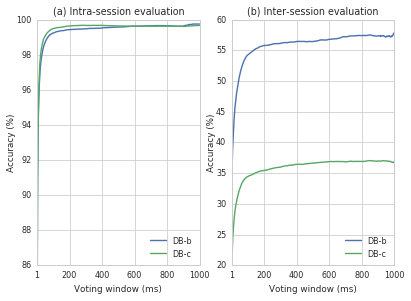

In [19]:
plt.subplot(121)
CapgMyo(dataset='dbb', version='958.14.1', crossval='intra-subject', label='DB-b',
        num_gesture=8, num_fold=100, threshold=[0.9, 0.95, 0.99]).plot_voting_curve()
CapgMyo(dataset='dbc', version='958.15.1', crossval='intra-subject', label='DB-c',
        num_gesture=12, num_fold=100, threshold=[0.9, 0.95, 0.99]).plot_voting_curve()
plt.legend(loc='lower right')
plt.title('(a) Intra-session evaluation')
plt.subplot(122)
print('---')
CapgMyo(dataset='dbb', version='958.7', crossval='inter-subject', label='DB-b', ymin=20, ymax=60,
        num_gesture=8, num_fold=10, threshold=[0.9, 0.95, 0.99]).plot_voting_curve()
CapgMyo(dataset='dbc', version='958.8', crossval='inter-subject', label='DB-c', ymin=20, ymax=60,
        num_gesture=12, num_fold=10, threshold=[0.9, 0.95, 0.99]).plot_voting_curve()
plt.legend(loc='lower right')
plt.title('(b) Inter-session evaluation')

## Voting Curves for CSL-HDEMG

No voting           55.8
Std                  5.9
150ms voting        89.3
Trial voting        96.8
90.400000% window  171.0
95.000000% window  370.0
---
No voting           35.4
Std                  9.4
150ms voting        69.3
Trial voting        82.3
58.900000% window   48.0
75.400000% window  263.0
80.000000% window  448.0


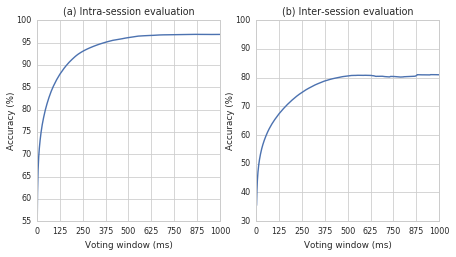

In [3]:
plt.subplot(121)
CSL(version='958.5.1.1', crossval='intra-session', num_fold=250,
    num_epoch=28, threshold=[0.904, 0.95]).plot_voting_curve()
plt.title('(a) Intra-session evaluation')
plt.subplot(122)
print('---')
CSL(version='958.4.1', crossval='inter-session', num_fold=25, threshold=[0.589, 0.754, 0.8]).plot_voting_curve()
plt.title('(b) Inter-session evaluation')
plt.gcf().set_size_inches(7.20472, 7.20472 / 2)
savefig('../.cache/figures/chi-csl-curve')

In [9]:
184./1000*2048, 390./1000*2048

(376.832, 798.72)

In [23]:
np.array([48.,263.,448.,150])/1000*2048

array([  98.304,  538.624,  917.504,  307.2  ])

In [4]:
np.array([171,370])/1000*2048

array([ 350.208,  757.76 ])

In [6]:
np.round(np.array([171,370])/1000*2048)/2048*1000/2

array([  85.44921875,  185.05859375])

## AdaBN Curves

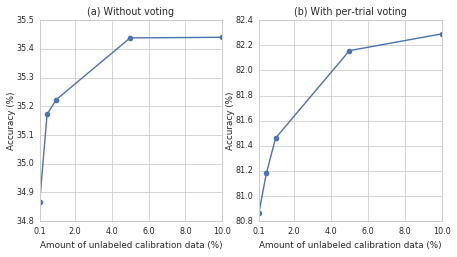

In [8]:
def plot(acc):
    plt.gca().plot([0.1, 0.5, 1, 5, 10], 100 * acc, '-o')
    plt.xlim(0.1, 10)
    plt.xticks([0.1, 2, 4, 6, 8, 10])
    plt.xlabel('Amount of unlabeled calibration data (%)')
    plt.ylabel('Accuracy (%)', labelpad=0)
    
    
def report(func):
    acc = np.array([
        func(version='958.4.1.1', mod=dict(downsample=0.001), batch_size=100),
        func(version='958.4.1.1', mod=dict(downsample=0.005), batch_size=100),
        func(version='958.4.1.1', mod=dict(downsample=0.01)),
        #func(version='958.4.1.1', mod=dict(downsample=0.02)),
        func(version='958.4.1.1', mod=dict(downsample=0.05)),
        func(version='958.4.1.1', mod=dict(downsample=0.1)),
        #get_acc(version='958.4.1'),
    ])
    plot(acc)


plt.subplot(121)
report(get_csl_inter_session_accuracy)
plt.title('(a) Without voting')

plt.subplot(122)
report(get_csl_inter_session_trial_accuracy)
plt.title('(b) With per-trial voting')

plt.gcf().set_size_inches(7.20472, 7.20472 / 2)
savefig('../.cache/figures/chi-adabn-curve')

In [22]:
400000*0.05/2048

9.765625

## Compare w/o AdaBN

No voting           29.3
Std                  9.1
150ms voting        53.0
Trial voting        62.5
58.900000% window  314.0
75.400000% window    0.0
80.000000% window    0.0


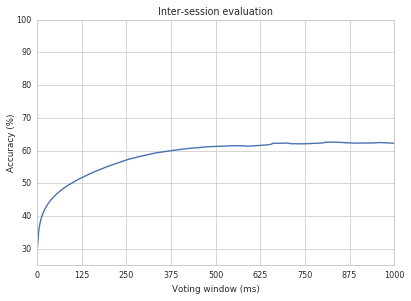

In [3]:
CSL(version='959.5.1', crossval='inter-session', num_fold=25,
    threshold=[0.589, 0.754, 0.8], adabn=False).plot_voting_curve()
plt.title('Inter-session evaluation')

No voting          31.4
Std                 7.8
150ms voting       39.0
Trial voting       39.2
90.000000% window   0.0
95.000000% window   0.0
99.000000% window   0.0
No voting          18.9
Std                 3.1
150ms voting       26.3
Trial voting       26.5
90.000000% window   0.0
95.000000% window   0.0
99.000000% window   0.0
No voting     35.0
Std           12.2
150ms voting  47.9
Trial voting  48.9


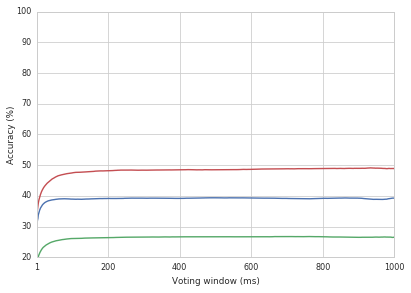

In [4]:
CapgMyo(dataset='dbb', version='960.21', crossval='inter-subject', label='DB-b', ymin=20, ymax=60,
        num_gesture=8, num_fold=10, threshold=[0.9, 0.95, 0.99], adabn=False).plot_voting_curve()
CapgMyo(dataset='dbc', version='960.22', crossval='inter-subject', label='DB-c', ymin=20, ymax=60,
        num_gesture=12, num_fold=10, threshold=[0.9, 0.95, 0.99], adabn=False).plot_voting_curve()
CapgMyo(dataset='dbb', version='960.23.1', crossval='inter-session', label='DB-b',
        num_gesture=8, folds=range(1, 20, 2), num_epoch=14, threshold=[], adabn=False).plot_voting_curve()

## Compare Network Architectures

In [3]:
exps = [Exp(dataset=Dataset.from_name('csl'),
            dataset_args=dict(preprocess=Preprocess.parse('(csl-bandpass,csl-cut,median,peak-256)')),
            Mod=dict(num_gesture=27,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=24, num_semg_col=7, num_filter=64),
                     params='.cache/sigr-csl-intra-session-%d-v958.5.1/model-0014.params'))]
evaluation = CrossValEvaluation(crossval_type='intra-session', batch_size=1000)
with Context(parallel=True, level='DEBUG'):
    acc = evaluation.accuracies([Exp(vote=-1, **e)for e in exps], folds=range(250))
acc.mean()

0.93979851851851715

In [15]:
evaluation = CrossValEvaluation(crossval_type='intra-session', batch_size=1000)
exps = [Exp(dataset=Dataset.from_name('csl'),
            dataset_args=dict(preprocess=Preprocess.parse('(csl-bandpass,csl-cut,median)')),
            Mod=dict(num_gesture=27,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=24, num_semg_col=7, num_filter=64),
                     params='.cache/sigr-csl-intra-session-%d-v958.5.1/model-0014.params')),
        Exp(dataset=Dataset.from_name('csl'),
            dataset_args=dict(preprocess=Preprocess.parse('(csl-bandpass,csl-cut,median)')),
            Mod=dict(num_gesture=27,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=24, num_semg_col=7, num_filter=64,
                                       num_pixel=0),
                     params='.cache/sigr-csl-intra-session-%d-v958.18.1/model-0014.params')),
        Exp(dataset=Dataset.from_name('csl'),
            dataset_args=dict(preprocess=Preprocess.parse('(csl-bandpass,csl-cut,median)')),
            Mod=dict(num_gesture=27,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=24, num_semg_col=7, num_filter=64,
                                       num_pixel=0, num_conv=4),
                     params='.cache/sigr-csl-intra-session-%d-v958.19.1/model-0014.params'))]
with Context(parallel=True, level='DEBUG'):
    acc = 100 * evaluation.vote_accuracy_curves(exps, folds=range(250), windows=[1], balance=True)
    acc_vote = 100 * evaluation.accuracies([Exp(vote=-1, **e)for e in exps], folds=range(250))

[acc.mean(axis=1).ravel(), acc_vote.mean(axis=1).ravel()]

[array([ 56.3968768 ,  54.17074364,  54.47233214]),
 array([ 96.66133333,  96.80948148,  96.79466667])]

In [17]:
evaluation = CrossValEvaluation(crossval_type='inter-session', batch_size=1000)
exps = [Exp(dataset=Dataset.from_name('csl'),
            dataset_args=dict(preprocess=Preprocess.parse('(csl-bandpass,csl-cut,median)')),
            Mod=dict(num_gesture=27,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=24, num_semg_col=7, num_filter=64),
                     params='.cache/sigr-inter-session-%d-v958.4.1/model-0014.params')),
        Exp(dataset=Dataset.from_name('csl'),
            dataset_args=dict(preprocess=Preprocess.parse('(csl-bandpass,csl-cut,median)')),
            Mod=dict(num_gesture=27,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=24, num_semg_col=7, num_filter=64,
                                       num_pixel=0),
                     params='.cache/sigr-csl-inter-session-%d-v958.18.4/model-0014.params')),
        Exp(dataset=Dataset.from_name('csl'),
            dataset_args=dict(preprocess=Preprocess.parse('(csl-bandpass,csl-cut,median)')),
            Mod=dict(num_gesture=27,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=24, num_semg_col=7, num_filter=64,
                                       num_pixel=0, num_conv=4),
                     params='.cache/sigr-csl-inter-session-%d-v958.19.4/model-0014.params'))]
with Context(parallel=True, level='DEBUG'):
    acc = 100 * evaluation.vote_accuracy_curves(exps, folds=range(25), windows=[1], balance=True)
    acc_vote = 100 * evaluation.accuracies([Exp(vote=-1, **e)for e in exps], folds=range(25))

[acc.mean(axis=1).ravel(), acc_vote.mean(axis=1).ravel()]

[array([ 35.43454619,  34.14773176,  32.65778828]),
 array([ 82.27595357,  81.69994472,  79.52072968])]

### DB-b intra-subject

In [5]:
exps = [Exp(dataset=Dataset.from_name('dbb'),
            Mod=dict(num_gesture=8,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=16, num_semg_col=8, num_filter=64),
                     params='.cache/sigr-dbb-intra-subject-%d-v958.14.1/model-0028.params')),
        Exp(dataset=Dataset.from_name('dbb'),
            Mod=dict(num_gesture=8,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=16, num_semg_col=8, num_filter=64,
                                       num_pixel=0),
                     params='.cache/sigr-dbb-intra-subject-%d-v960.8.1/model-0028.params')),
        Exp(dataset=Dataset.from_name('dbb'),
            Mod=dict(num_gesture=8,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=16, num_semg_col=8, num_filter=64,
                                       num_pixel=0, num_conv=4),
                     params='.cache/sigr-dbb-intra-subject-%d-v960.14.1/model-0028.params'))]
with Context(parallel=True, level='DEBUG'):
    evaluation = CrossValEvaluation(crossval_type='intra-subject', batch_size=1000)
    acc = 100 * evaluation.accuracies(exps, folds=range(100))
    acc_vote = 100 * evaluation.accuracies([Exp(vote=-1, **e)for e in exps], folds=range(100))

[acc.mean(axis=1).ravel(), acc_vote.mean(axis=1).ravel()]

[array([ 87.524125,  85.51525 ,  85.619375]),
 array([ 99.75 ,  99.625,  99.625])]

### DB-b inter-subject

In [2]:
exps = [Exp(dataset=Dataset.from_name('dbb'),
            Mod=dict(num_gesture=8,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=16, num_semg_col=8, num_filter=64),
                     params='.cache/sigr-dbb-inter-subject-%d-v958.7/model-0028.params')),
        Exp(dataset=Dataset.from_name('dbb'),
            Mod=dict(num_gesture=8,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=16, num_semg_col=8, num_filter=64,
                                       num_pixel=0),
                     params='.cache/sigr-dbb-inter-subject-%d-v960.10/model-0028.params')),
        Exp(dataset=Dataset.from_name('dbb'),
            Mod=dict(num_gesture=8,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=16, num_semg_col=8, num_filter=64,
                                       num_pixel=0, num_conv=4),
                     params='.cache/sigr-dbb-inter-subject-%d-v960.16/model-0028.params'))]
with Context(parallel=True, level='DEBUG'):
    evaluation = CrossValEvaluation(crossval_type='inter-subject', batch_size=1000)
    acc = 100 * evaluation.accuracies(exps, folds=range(10))
    acc_vote = 100 * evaluation.accuracies([Exp(vote=-1, **e)for e in exps], folds=range(10))

[acc.mean(axis=1).ravel(), acc_vote.mean(axis=1).ravel()]

[array([ 35.108375,  33.329625,  32.6635  ]),
 array([ 57.875,  57.375,  56.   ])]

### DB-c intra-subject

In [3]:
exps = [Exp(dataset=Dataset.from_name('dbc'),
            Mod=dict(num_gesture=12,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=16, num_semg_col=8, num_filter=64),
                     params='.cache/sigr-dbc-intra-subject-%d-v958.15.1/model-0028.params')),
        Exp(dataset=Dataset.from_name('dbc'),
            Mod=dict(num_gesture=12,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=16, num_semg_col=8, num_filter=64,
                                       num_pixel=0),
                     params='.cache/sigr-dbc-intra-subject-%d-v960.9.1/model-0028.params')),
        Exp(dataset=Dataset.from_name('dbc'),
            Mod=dict(num_gesture=12,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=16, num_semg_col=8, num_filter=64,
                                       num_pixel=0, num_conv=4),
                     params='.cache/sigr-dbc-intra-subject-%d-v960.15.1/model-0028.params'))]
with Context(parallel=True, level='DEBUG'):
    evaluation = CrossValEvaluation(crossval_type='intra-subject', batch_size=1000)
    acc = 100 * evaluation.accuracies(exps, folds=range(100))
    acc_vote = 100 * evaluation.accuracies([Exp(vote=-1, **e)for e in exps], folds=range(100))

[acc.mean(axis=1).ravel(), acc_vote.mean(axis=1).ravel()]

[array([ 86.0055    ,  82.31233333,  82.83141667]),
 array([ 99.66666667,  99.58333333,  99.66666667])]

### DB-c inter-subject

In [4]:
exps = [Exp(dataset=Dataset.from_name('dbc'),
            Mod=dict(num_gesture=12,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=16, num_semg_col=8, num_filter=64),
                     params='.cache/sigr-dbc-inter-subject-%d-v958.8/model-0028.params')),
        Exp(dataset=Dataset.from_name('dbc'),
            Mod=dict(num_gesture=12,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=16, num_semg_col=8, num_filter=64,
                                       num_pixel=0),
                     params='.cache/sigr-dbc-inter-subject-%d-v960.11/model-0028.params')),
        Exp(dataset=Dataset.from_name('dbc'),
            Mod=dict(num_gesture=12,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=16, num_semg_col=8, num_filter=64,
                                       num_pixel=0, num_conv=4),
                     params='.cache/sigr-dbc-inter-subject-%d-v960.17/model-0028.params'))]
with Context(parallel=True, level='DEBUG'):
    evaluation = CrossValEvaluation(crossval_type='inter-subject', batch_size=1000)
    acc = 100 * evaluation.accuracies(exps, folds=range(10))
    acc_vote = 100 * evaluation.accuracies([Exp(vote=-1, **e)for e in exps], folds=range(10))

[acc.mean(axis=1).ravel(), acc_vote.mean(axis=1).ravel()]

[array([ 21.18116667,  20.72258333,  19.52983333]),
 array([ 36.83333333,  38.25      ,  37.        ])]

In [5]:
exps = [Exp(dataset=Dataset.from_name('ninapro-db1/caputo'),
            Mod=dict(num_gesture=52,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=1, num_semg_col=10, num_filter=64),
                     params='.cache/sigr-ninapro-db1-caputo-one-fold-intra-subject-%d-v959.11.1/model-0028.params')),
        Exp(dataset=Dataset.from_name('ninapro-db1/caputo'),
            Mod=dict(num_gesture=52,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=1, num_semg_col=10, num_filter=64,
                                       num_pixel=0),
                     params='.cache/sigr-ninapro-db1-caputo-one-fold-intra-subject-%d-v960.13.1/model-0028.params')),
        Exp(dataset=Dataset.from_name('ninapro-db1/caputo'),
            Mod=dict(num_gesture=52,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=1, num_semg_col=10, num_filter=64,
                                       num_pixel=0, num_conv=4),
                     params='.cache/sigr-ninapro-db1-caputo-one-fold-intra-subject-%d-v960.19.1/model-0028.params'))]
with Context(parallel=True, level='DEBUG'):
    evaluation = CrossValEvaluation(crossval_type='one-fold-intra-subject', batch_size=1000)
    acc = 100 * evaluation.accuracies(exps, folds=range(27))
    acc_vote = 100 * evaluation.accuracies([Exp(vote=40, **e)for e in exps], folds=range(27))

[acc.mean(axis=1).ravel(), acc_vote.mean(axis=1).ravel()]

[array([ 56.46206109,  59.3783443 ,  59.26929081]),
 array([ 67.40612087,  71.13240636,  71.91860461])]

## Experiments on CapgMyo

No voting          87.5
Std                 6.3
150ms voting       99.4
Trial voting       99.8
90.000000% window   3.0
95.000000% window  10.0
99.000000% window  67.0
No voting          86.0
Std                 6.8
150ms voting       99.6
Trial voting       99.7
90.000000% window   4.0
95.000000% window   9.0
99.000000% window  46.0
---
No voting          35.1
Std                 7.9
150ms voting       55.3
Trial voting       57.9
90.000000% window   0.0
95.000000% window   0.0
99.000000% window   0.0
No voting          21.2
Std                 4.6
150ms voting       35.1
Trial voting       36.8
90.000000% window   0.0
95.000000% window   0.0
99.000000% window   0.0


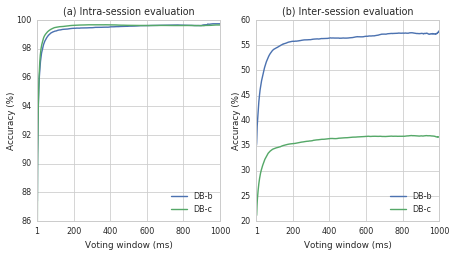

In [18]:
plt.subplot(121)
CapgMyo(dataset='dbb', version='958.14.1', crossval='intra-subject', label='DB-b',
        num_gesture=8, num_fold=100, threshold=[0.9, 0.95, 0.99]).plot_voting_curve()
CapgMyo(dataset='dbc', version='958.15.1', crossval='intra-subject', label='DB-c',
        num_gesture=12, num_fold=100, threshold=[0.9, 0.95, 0.99]).plot_voting_curve()
plt.legend(loc='lower right')
plt.title('(a) Intra-session evaluation')
plt.subplot(122)
print('---')
CapgMyo(dataset='dbb', version='958.7', crossval='inter-subject', label='DB-b', ymin=20, ymax=60,
        num_gesture=8, num_fold=10, threshold=[0.9, 0.95, 0.99]).plot_voting_curve()
CapgMyo(dataset='dbc', version='958.8', crossval='inter-subject', label='DB-c', ymin=20, ymax=60,
        num_gesture=12, num_fold=10, threshold=[0.9, 0.95, 0.99]).plot_voting_curve()
plt.legend(loc='lower right')
plt.title('(b) Inter-session evaluation')
plt.gcf().set_size_inches(7.20472, 7.20472 / 2)
savefig('../.cache/figures/chi-capgmyo-curve')

No voting     38.9
Std           15.1
150ms voting  57.5
Trial voting  60.2


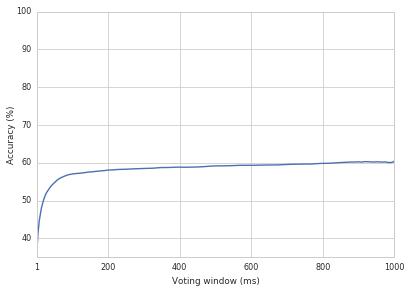

In [8]:
CapgMyo(dataset='dbb', version='959.13.1', crossval='inter-session', label='DB-b',
        num_gesture=8, folds=range(1, 20, 2), num_epoch=14, threshold=[]).plot_voting_curve()

No voting     41.2
Std           10.3
150ms voting  63.3
Trial voting  65.8


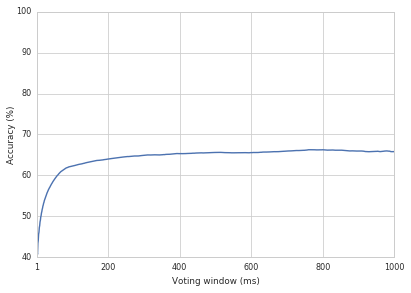

In [2]:
CapgMyo(dataset='dbb', version='959.13.4', crossval='inter-session', label='DB-b',
        num_gesture=8, folds=range(1, 20, 2), num_epoch=14, threshold=[]).plot_voting_curve()

No voting     40.2
Std            9.8
150ms voting  62.0
Trial voting  65.3


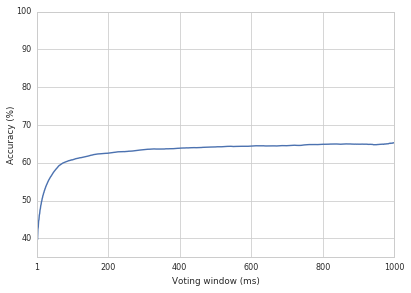

In [2]:
CapgMyo(dataset='dbb', version='959.13', crossval='inter-session', label='DB-b',
        params='.cache/sigr-dbb-universal-inter-session-1-v959.13/model-0028.params',
        num_gesture=8, folds=range(1, 20, 2), num_epoch=28, threshold=[]).plot_voting_curve()

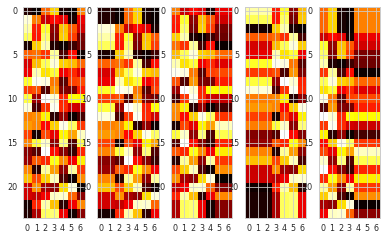

In [3]:
from sigr.data import _shift


def shift(a, hs, vs):
    return _shift(a[np.newaxis, :, :], hs, vs, 'margin').reshape(a.shape)


a = np.random.rand(24, 7)
plt.subplot(151)
plt.imshow(shift(a, 0, 0), cmap='hot_r', interpolation='nearest')
plt.subplot(152)
plt.imshow(shift(a, 1, 1), cmap='hot_r', interpolation='nearest')
plt.subplot(153)
plt.imshow(shift(a, -1, -1), cmap='hot_r', interpolation='nearest')
plt.subplot(154)
plt.imshow(shift(a, 2, -2), cmap='hot_r', interpolation='nearest')
plt.subplot(155)
plt.imshow(shift(a, -2, 2), cmap='hot_r', interpolation='nearest')

## NinaPro AdaBN

No voting          59.0
Std                 4.7
150ms voting       70.3
Trial voting       93.7
40.000000% window  10.0


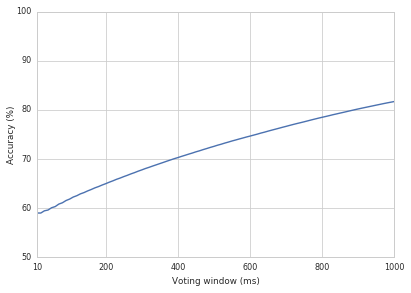

In [3]:
NinaPro(dataset='ninapro-db1', crossval='one-fold-intra-subject', version='959.6.1', num_gesture=52,
        adabn=False, w150=40, threshold=0.4, ymin=50).plot_voting_curve()

No voting          58.6
Std                 4.7
150ms voting       69.7
Trial voting       93.3
40.000000% window  10.0


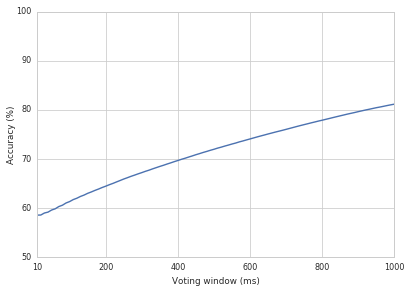

In [5]:
NinaPro(dataset='ninapro-db1', crossval='one-fold-intra-subject', version='959.8.1', num_gesture=52,
        adabn=False, w150=40, threshold=0.4, ymin=50).plot_voting_curve()

No voting          58.6
Std                 4.8
150ms voting       69.7
Trial voting       93.2
40.000000% window  10.0


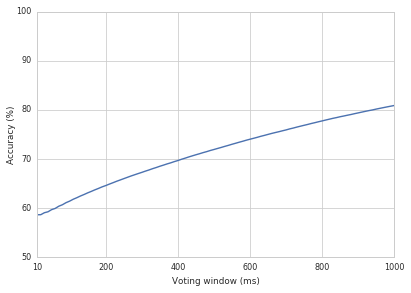

In [6]:
NinaPro(dataset='ninapro-db1', crossval='one-fold-intra-subject', version='959.9.1', num_gesture=52,
        adabn=False, w150=40, threshold=0.4, ymin=50, balance=False).plot_voting_curve()

../sigr/vote.py:18: UserWarning: Persisting input arguments took 0.82s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  balance)


No voting          56.5
Std                 4.9
150ms voting       67.4
Trial voting       91.6
40.000000% window  10.0


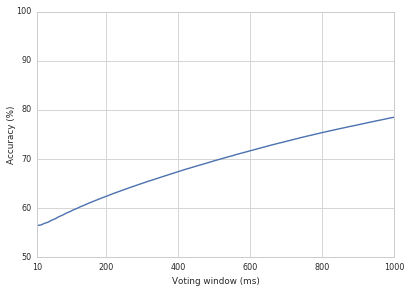

In [3]:
NinaPro(dataset='ninapro-db1/caputo', crossval='one-fold-intra-subject', version='959.11.1', num_gesture=52,
        adabn=False, w150=40, threshold=0.4, ymin=50, balance=False).plot_voting_curve()

## t-SNE

In [6]:
cv = CrossValEvaluation(crossval_type='inter-session', batch_size=1000)
with Context(parallel=True, level='DEBUG'):
    feat, true = [], []
    for i in [20, 21, 22, 23]:
        ret = cv.transform(
            dataset=Dataset.from_name('csl'),
            dataset_args=dict(preprocess=Preprocess.parse('(csl-bandpass,csl-cut,median)')),
            Mod=dict(num_gesture=27,
                     adabn=True,
                     num_adabn_epoch=10,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=24, num_semg_col=7, num_filter=64, output='fc1_relu_output'),
                     params='.cache/sigr-inter-session-24-v958.4.1/model-0014.params'),
            fold=i)
        feat.append(ret[0])
        true.append(ret[1])
    feat = np.vstack(feat)
    true = np.hstack(true)

[2016-09-21 13:45:15.709635] DEBUG: csl: /code/.cache/csl/subject5/session1/gest1.mat
[2016-09-21 13:45:15.887230] DEBUG: csl: /code/.cache/csl/subject5/session1/gest2.mat
[2016-09-21 13:45:16.111958] DEBUG: csl: /code/.cache/csl/subject5/session1/gest3.mat
[2016-09-21 13:45:16.313074] DEBUG: csl: /code/.cache/csl/subject5/session1/gest4.mat
[2016-09-21 13:45:16.519827] DEBUG: csl: /code/.cache/csl/subject5/session1/gest5.mat
[2016-09-21 13:45:16.763362] DEBUG: csl: /code/.cache/csl/subject5/session1/gest6.mat
[2016-09-21 13:45:17.012884] DEBUG: csl: /code/.cache/csl/subject5/session1/gest7.mat
[2016-09-21 13:45:17.244212] DEBUG: csl: /code/.cache/csl/subject5/session1/gest8.mat
[2016-09-21 13:45:17.542170] DEBUG: csl: /code/.cache/csl/subject5/session1/gest9.mat
[2016-09-21 13:45:17.827905] DEBUG: csl: /code/.cache/csl/subject5/session1/gest10.mat
[2016-09-21 13:45:18.107628] DEBUG: csl: /code/.cache/csl/subject5/session1/gest11.mat
[2016-09-21 13:45:18.402381] DEBUG: csl: /code/.cach

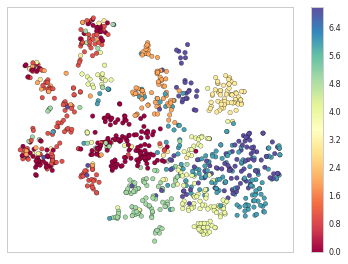

In [13]:
from sklearn import manifold
from matplotlib.ticker import NullFormatter


ind = np.arange(len(feat))
ind = ind[true < 8]
np.random.RandomState(42).shuffle(ind)
X = feat[ind[:1000]]
color = true[ind[:1000]]

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y = tsne.fit_transform(X)
ax = plt.gca()
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.colorbar()
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
plt.grid(None)

In [4]:
cv = CrossValEvaluation(crossval_type='inter-session', batch_size=1000)
with Context(parallel=True, level='DEBUG'):
    feat, true = [], []
    for i in [20, 21, 22, 23]:
        ret = cv.transform(
            dataset=Dataset.from_name('csl'),
            dataset_args=dict(preprocess=Preprocess.parse('(csl-bandpass,csl-cut,median)')),
            Mod=dict(num_gesture=27,
                     context=[mx.gpu(0)],
                     symbol_kargs=dict(dropout=0, num_semg_row=24, num_semg_col=7, num_filter=64, output='fc1_relu_output'),
                     params='.cache/sigr-inter-session-24-v959.5.1/model-0014.params'),
            fold=i)
        feat.append(ret[0])
        true.append(ret[1])
    feat = np.vstack(feat)
    true = np.hstack(true)

[2016-09-21 13:40:49.863218] DEBUG: csl: /code/.cache/csl/subject5/session1/gest1.mat
[2016-09-21 13:40:50.049204] DEBUG: csl: /code/.cache/csl/subject5/session1/gest2.mat
[2016-09-21 13:40:50.271677] DEBUG: csl: /code/.cache/csl/subject5/session1/gest3.mat
[2016-09-21 13:40:50.505926] DEBUG: csl: /code/.cache/csl/subject5/session1/gest4.mat
[2016-09-21 13:40:50.706104] DEBUG: csl: /code/.cache/csl/subject5/session1/gest5.mat
[2016-09-21 13:40:50.986082] DEBUG: csl: /code/.cache/csl/subject5/session1/gest6.mat
[2016-09-21 13:40:51.245542] DEBUG: csl: /code/.cache/csl/subject5/session1/gest7.mat
[2016-09-21 13:40:51.477066] DEBUG: csl: /code/.cache/csl/subject5/session1/gest8.mat
[2016-09-21 13:40:51.776633] DEBUG: csl: /code/.cache/csl/subject5/session1/gest9.mat
[2016-09-21 13:40:52.071104] DEBUG: csl: /code/.cache/csl/subject5/session1/gest10.mat
[2016-09-21 13:40:52.352627] DEBUG: csl: /code/.cache/csl/subject5/session1/gest11.mat
[2016-09-21 13:40:52.622965] DEBUG: csl: /code/.cach

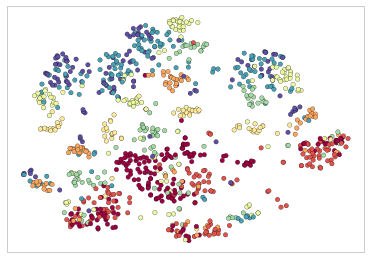

In [5]:
from sklearn import manifold
from matplotlib.ticker import NullFormatter


ind = np.arange(len(feat))
ind = ind[true < 8]
np.random.RandomState(42).shuffle(ind)
X = feat[ind[:1000]]
color = true[ind[:1000]]

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y = tsne.fit_transform(X)
ax = plt.gca()
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
plt.grid(None)